In [1]:
from glob import glob as gg
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import rc as rc
#
import pandas as pd
#
from datetime import datetime as datetime
#
from netCDF4 import Dataset  

In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
#
# parameters for the processing step of the atmospheric deposition (CO2, Fe and nitrogen)
# 
mesh_name='farc'
# path to data
path_data = '../../data/'

# computation mesh information: path and filename
path_mesh = path_data + 'MESH/'
filename_mesh = path_mesh + 'REcoM1D_mesh_v2.nc'

# information about mesh on which atm deposition data are computed from
path_mesh_atm_deposition = path_mesh +'mesh/' + mesh_name + '/'
filename_mesh_atm_deposition = path_mesh_atm_deposition + 'nod2d.out'

# atm deposition data path
path_atm =  path_data + 'atm_deposition/'

# CO2 deposition file name
filename_CO2 = path_atm + 'MonthlyAtmCO2_gcb2021.nc'

# Nitrogen deposition file name
filename_N = path_atm + mesh_name +'/'+ 'AeolianNitrogenDep.nc'

# Fe deposition type and file name
Fe_climatology_type='climatology_Albani'
name = 'DustClimMonthly' if 'climatology' in Fe_climatology_type else 'DustMonthly'
name = name + 'Albani.nc' if 'Albani' in Fe_climatology_type else name + 'Mahowald.nc'
filename_Fe = path_atm + mesh_name +'/'+ name

# output deposition file name 
filename_output = path_atm + 'atm_deposition_v2.nc'

In [3]:
# 1. mesh
# 1.1 load simulation mesh information: dates and geo-coordinates
#
class mesh_data:
    def __init__(self, filename):
        self.read_mesh_information(filename)
        
    def read_mesh_information(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        
        # define month and year related to the dates
        month, year = [], []
        for dt in self.dates:
            tmp = datetime.fromordinal(int(dt))
            month.append(tmp.month), year.append(tmp.year)
        self.month, self.year = np.asarray(month), np.asarray(year)
        # read vertical mesh
        self.longitude, self.latitude = ncid.variables['longitude'][:], ncid.variables['latitude'][:]
        
        ncid.close()
#
# read mesh information
#
mesh = mesh_data(filename_mesh)

In [4]:
# 1.2 load mesh coordinates on which the data is computed on

class mesh_deposition_data:
    def __init__(self, filename, latmin):
        self.read_mesh(filename)
        self.truncate_mesh(latmin)
    def read_mesh(self,filename):
        data = pd.read_csv(filename, sep='\s+', skiprows=1 , header=None)
        self.longitude, self.latitude = data.iloc[:,1], data.iloc[:,2]
    def truncate_mesh(self,latmin):
        indices=np.where(self.latitude>=latmin-0.5)[0]
        self.indices = indices
        self.longitude, self.latitude = self.longitude[indices], self.latitude[indices]

#
mesh_deposition = mesh_deposition_data(filename_mesh_atm_deposition, np.min(mesh.latitude))

In [5]:
# 1.3 look for the time series of indices in the deposition mesh that correspond to the track position 
#
# routine to estimate distance in between 2 points given their coordinates
def tunnel_distance_nearest_neighbor_index(lon, lat, longitude_ref, latitude_ref):
    #
    # estimate nearest neighbor of (lon,lat) point and return point index
    #
    # convert lon, lat to radian
    deg2rad = np.pi / 180.0
    lon, lat, longitude_ref, latitude_ref =  deg2rad*lon, deg2rad*lat , deg2rad*longitude_ref, deg2rad*latitude_ref
    
    #compute cos,sin and cross-products for of the different a lon,lat arrays
    # grid
    clat, clon, slat, slon = np.cos(lat), np.cos(lon), np.sin(lat), np.sin(lon)
    clat_clon,  clat_slon = clat * clon, clat * slon
    
    # reference node
    clat_ref, clon_ref, slat_ref, slon_ref = np.cos(latitude_ref), np.cos(longitude_ref), np.sin(latitude_ref), np.sin(longitude_ref)
    clat_clon_ref,  clat_slon_ref = clat_ref * clon_ref, clat_ref * slon_ref
    
    # compute tunnel distance to the different grid nodes
    distance = []
    dX, dY, dZ = clat_clon - clat_clon_ref, clat_slon - clat_slon_ref, slat - slat_ref
    distance = dX**2 + dY**2 + dZ**2

    return np.argmin(distance)

# look for corresponding mesh/track indices
class Spatio_temporal_indices:
    def __init__(self, track, mesh):
        # estimate temporal indices
        self.estimate_temporal_indices(track)
        # estimate spatial indices
        self.estimate_spatial_indices(track,mesh)
        
    def estimate_temporal_indices(self,track):
        indices=[]
        for dt in track.dates:
            indices.append(datetime.fromordinal(int(dt)).month-1)
        self.time_indices = np.asarray(indices)
            
    def estimate_spatial_indices(self,track, mesh):
        indices=[]
        for i in range(len(track.dates)):
            lon, lat = track.longitude[i],track.latitude[i]
            index=tunnel_distance_nearest_neighbor_index(mesh.longitude, mesh.latitude, lon, lat)
            indices.append(index)
        self.space_indices=np.asarray(indices)
#
indices = Spatio_temporal_indices(mesh, mesh_deposition)

In [6]:
# 2. CO2 surface deposition
#
# read CO2 surface deposition
# monthly data (independant of the mesh)
class CO2_deposition_data:
    def __init__(self, filename, mesh):
        # read CO2 input file
        self.read_CO2_input(filename, mesh)
        # estimate CO2 input along the track
        self.estimate_CO2_deposition(mesh)
        
    def read_CO2_input(self,filename, data):
        # look for required years
        years = np.unique(data.year)
        
        # path to data
        ncid = Dataset(filename, "r", format="NETCDF4") 
        CO2_data=[]
        for yr in years:
            gp_name = 'AtmCO2_' + str(yr)
            CO2_data.append(ncid.variables[gp_name][:])
        self.CO2_data = np.asarray(CO2_data)
        self.CO2_years = years
        ncid.close()
        
    def estimate_CO2_deposition(self, data):
        CO2_deposition = []
        for i in range(len(data.dates)):
            month, year = data.month[i], data.year[i]
            indy = np.argmin(abs(self.CO2_years-year))
            CO2_deposition.append(self.CO2_data[indy][int(month)-1])
            self.CO2_deposition = np.asarray(CO2_deposition)
            
#
# read CO2 input
#
CO2_input = CO2_deposition_data(filename_CO2, mesh)

In [7]:
# 3. Nitrogen surface deposition
#
class N_deposition_data:
    def __init__(self, filename, indices, mesh_indices):
        
        # read Nitrogen input file
        self.read_N_dataset(filename, mesh_indices)
        
        # estimate Nitrogen deposition
        self.estimate_N_deposition(indices)
        
    def read_N_dataset(self,filename, mesh_indices):        
        ncid = Dataset(filename, "r", format="NETCDF4") 
        N_data = ncid.variables['NDep2009'][:]
        self.N_data = N_data[mesh_indices]
        ncid.close()
        
    def estimate_N_deposition(self, indices):
        N_deposition = []
        for i in range(len(indices.time_indices)):
            N_deposition.append(self.N_data[indices.space_indices[i]])
            
        self.N_deposition = np.asarray(N_deposition)

    
#
#
N_input = N_deposition_data(filename_N, indices, mesh_deposition.indices)

In [8]:
# 4. Fe surface deposition
# rk: different data sets are available for atm deposition

class Fe_deposition_data:
    def __init__(self, filename, indices, mesh_indices):
        
        # read Fe input file
        self.read_Fe_dataset(filename, mesh_indices)
        # estimate Fe deposition
        self.estimate_Fe_deposition(indices)
        
    def read_Fe_dataset(self,filename, mesh_indices):        
        ncid = Dataset(filename, "r", format="NETCDF4") 
        Fe_data = ncid.variables['DustClim'][:]
        self.Fe_data = Fe_data[:,mesh_indices]
        ncid.close()
        
    def estimate_Fe_deposition(self, indices):
        Fe_deposition = []
        for i in range(len(indices.time_indices)):
            idt, idx = indices.time_indices[i], indices.space_indices[i]
            Fe_deposition.append(self.Fe_data[idt,idx])
            
        self.Fe_deposition = np.asarray(Fe_deposition)

# load Fe deposition data    
Fe_input = Fe_deposition_data(filename_Fe, indices, mesh_deposition.indices)

1.3608851141271948e-05
3.044520852541762e-07
411.0048028772454


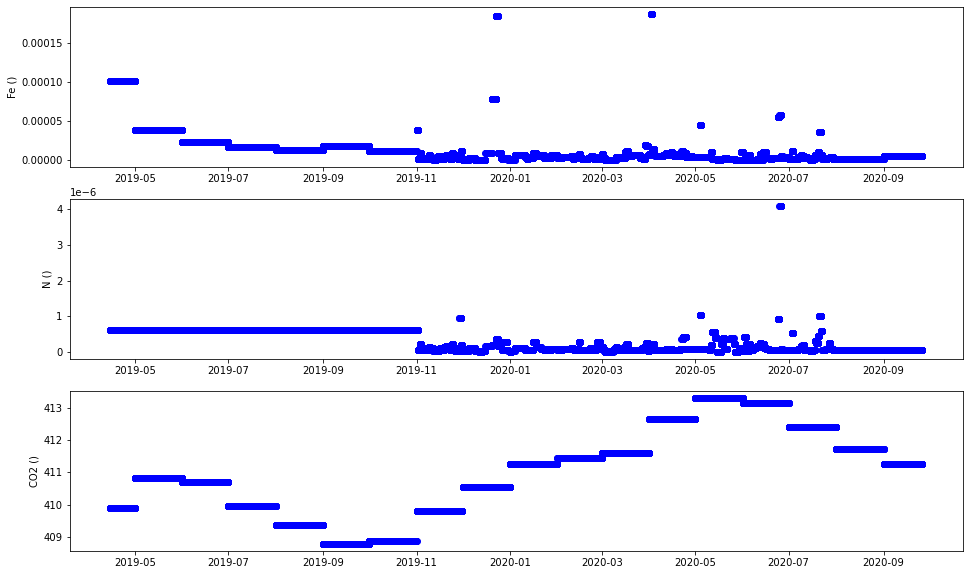

In [9]:
#
# 5. plot the different deposition time series 
#
date_ref = datetime.strptime('1970-01-01', '%Y-%m-%d').toordinal()
dt = mesh.dates-date_ref

# plot various deposition
fig, ax = plt.subplots(3, figsize=(16,10))

# Fe
var = Fe_input.Fe_deposition
ax[0].plot_date(dt, var,'ob')
ax[0].set_ylabel('Fe ()')
print(np.mean(var))

#Nitrogen
var = N_input.N_deposition
ax[1].plot_date(dt, var, 'ob')
ax[1].set_ylabel('N ()')
print(np.mean(var))

# C02
var = CO2_input.CO2_deposition
ax[2].plot_date(dt,var,'ob')
ax[2].set_ylabel('CO2 ()')
print(np.mean(var))


In [10]:
#
# save atm deposition to netcdf
#
class Output:
    def __init__(self, filename, dates, CO2, Fe, N):
        self.write_recom_constant_forcing(filename, dates, CO2, Fe, N)
        
    def write_recom_constant_forcing(self, filename, dates, CO2, Fe, N):
        
        nt = len(dates)
        
        # store grid (Lagrangian and vertical) information
        ncid = Dataset(filename, "w", format="NETCDF4") 

        ## define dimensionss
        ncid.createDimension('time', nt)       

        ## create variables
        # dates
        dt = ncid.createVariable('dates', "f8",'time')
        
        # CO2
        co2 = ncid.createVariable('CO2_deposition', "f8",'time')
        # Fe
        fe = ncid.createVariable('Fe_deposition', "f8",'time')
        # N
        nit = ncid.createVariable('N_deposition', "f8",'time')

        # temperature and salinity
        co2.units, fe.units, nit.units ='ppm', 'umol/m2/s', 'mmol/m2/s'
        
        ## fill variables
        # dates
        ncid['dates'][:] = dates
        ncid['CO2_deposition'][:], ncid['Fe_deposition'][:], ncid['N_deposition'][:] = CO2, Fe, N
                
        #
        ncid.close()
        
#
Output(filename_output, mesh.dates, CO2_input.CO2_deposition, Fe_input.Fe_deposition, N_input.N_deposition)